In [50]:
import sys
import math
import csv
from collections import defaultdict, OrderedDict

import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt

from __future__ import division

%matplotlib inline

In [74]:
input_file = 't0_cpu_smt_on2.csv'
output_file = 'results_t0_smt_on2.csv'
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['jeditaskid', 'atlrel', 'cputype', 'njobs',
                                                              'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
                                                              'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [75]:
grouped = df.groupby(['jeditaskid', 'cputype'], as_index=False, sort=False)

data = defaultdict(OrderedDict)
for (j, s), g in grouped:
    x = np.average(g.cpuevt_avg, weights=g.cpu)
    y = math.sqrt(np.average((g.cpuevt_avg - x)**2, weights=g.cpu))
    data[j][s] = (x, y)

In [76]:
# Remove from data tasks with only one site
for (k, v) in data.items():
    if len(v) == 1:
        del data[k]

In [77]:
# Map cpus to integers
i = -1
sites = set()
smap = dict()
for (k, v) in data.items():
    for s in v.keys():
        if s not in sites:
            i += 1
            smap[s] = i
            sites.add(s)
        data[k][smap[s]] = data[k][s]
        del data[k][s]

In [78]:
# Map tasks to integers
tasks = set(data.keys())
tmap = dict()
i = 0
for x in tasks:
    tmap[x] = i
    i += 1

In [79]:
ntask = len(data)
nsite = len(smap)
a_ini = np.zeros(ntask)
for j, task in data.items():
    nt = tmap[j]
    a_ini[nt] = np.mean([b[0] for b in task.values()])
x_ini = np.hstack((a_ini, np.ones(nsite)))

In [80]:
print "Tasks: ", ntask
print "CPUs: ", nsite
print "Sum of initial values: ", np.sum(x_ini)

Tasks:  38
CPUs:  6
Sum of initial values:  547.731845308


In [81]:
def func_val(x):
    a = x[:ntask]
    k = x[ntask:]
    total = 0.
    for j, task in data.items():   # looping on tasks
        nt = tmap[j]
        kf = np.array([k[i] for i in task.keys()])
        v = np.array([b[0] for b in task.values()])
        f_term = 1. / a[nt]**2 * (v * kf - a[nt])**2
        delta = np.sum(f_term)
        total += delta
    return total

In [82]:
def grad_val(x):
    a = x[:ntask]
    k = x[ntask:]
    g = np.zeros(len(x))
    for j, task in data.items():
        g_a = 0.
        nt = tmap[j]
        for i in task.keys():
            (v, _) = task[i]
            g_a += -2 * v * k[i] / a[nt]**2 * (v * k[i] / a[nt] - 1)
            g_k = 2 / a[nt]**2 * v * (k[i] * v - a[nt])
            g[ntask + i] += g_k
        g[nt] = g_a
    return g

In [83]:
def hess_val(x):
    a = x[:ntask]
    k = x[ntask:]
    diag = np.zeros_like(x)   # diagonal of the Hessian
    H = np.diag(diag)
    for t, task in data.items():
        h = 0.
        nt = tmap[t]
        for i in task.keys():
            (v, _) = task[i]
            h += 2 / a[nt]**4 * (3 * v**2 * k[i]**2 - 2 * v * k[i] * a[nt])
            diag[ntask + i] += 2 * v**2 / a[nt]**2
            H[nt][ntask+i] = H[ntask+i][nt] = -2 * v / a[nt]**2 * ( 2 * v * k[i] / a[nt] - 1)
        diag[nt] = h
    H = H + np.diag(diag)
    return H

In [84]:
print 'Initial function value: ', func_val(x_ini)

Initial function value:  12.9758535846


In [85]:
check = optimize.check_grad(func_val, grad_val, x_ini)
print check

1.27355416451e-06


In [86]:
result = optimize.minimize(func_val, x_ini, method='Newton-CG', jac=grad_val, hess=hess_val, options={'disp': True, 'maxiter': 2000})

Optimization terminated successfully.
         Current function value: 4.432097
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 33
         Hessian evaluations: 16


In [87]:
x = result.x
a = x[:ntask]
k = x[ntask:]
k_err = np.zeros_like(k)

In [88]:
p = list()
for j, task in data.items():
    nt = tmap[j]
    for i in task.keys():
        (v, _) = task[i]
        p.append(v * x[ntask+i] / x[nt])
sigma = np.std(p)
print 'The value of S is: %.3f' % sigma

The value of S is: 0.159


In [89]:
c = 0
for j, task in data.items():
    nt = tmap[j]
    c += len(task)
    for i in task.keys():
        (v, _) = task[i]
        k_err[i] += v**2 / a[nt]**2
k_err = sigma / np.sqrt(k_err)

In [90]:
deg = c - len(x_ini)
chi2r = func_val(result.x) / sigma**2 / deg
print 'Degrees of freedom: %d' % deg
print 'The value of the reduced chi2 is: %.3f' % chi2r
print 'Standard deviation of reduced chi2: %.3f' % (1. / np.sqrt(2. * deg))

Degrees of freedom: 126
The value of the reduced chi2 is: 1.385
Standard deviation of reduced chi2: 0.063


In [91]:
with open(output_file, 'wb') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    for s in sorted(smap.keys()):
        w.writerow([s, k[smap[s]], k_err[smap[s]]])

The value of S is: 0.159


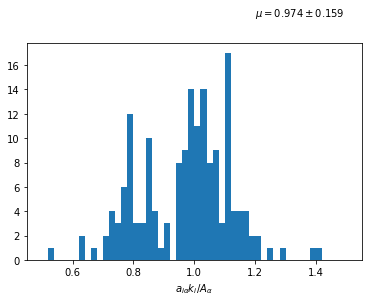

In [92]:
bins = 50
xrange = (0.5, 1.5)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(p, bins=bins, range=xrange)
n = len(p)
mu = np.mean(p)
sigma = np.std(p)
plt.xlabel(r'$a_{i\alpha}k_i/A_\alpha$')
plt.text(1.2, 20., r'$\mu=%.3f\pm%.3f$' % (mu, sigma))
S = sigma
print 'The value of S is: %.3f' % S

In [93]:
y1, x1 = np.histogram(p, bins=bins, range=xrange)
y1 = np.divide(y1, np.float(np.sum(y1))*binsize)

0.988518429873 0.147215789987
The value of S is: 0.147


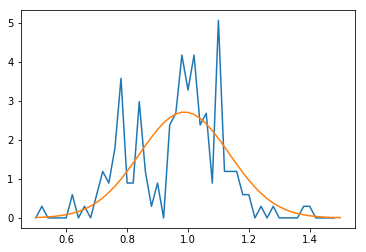

In [94]:
def f(x, m, s):
    return 1 / (s * np.sqrt(2 * np.pi)) * np.exp(-(x - m)**2 / (2 * s**2))

plt.plot(x1[:-1], y1)
(m, s), _ = optimize.curve_fit(f, x1[:-1], y1)
print m, s
plt.plot(x1, f(x1, m, s))
S1 = s
print 'The value of S is: %.3f' % S1

In [95]:
points2 = list()
for t, task in data.items():
    nt = tmap[t]
    for i in task.keys():
        (v, _) = task[i]
        p = v / a_ini[nt]
        points2.append(p)

The value of S is: 0.276


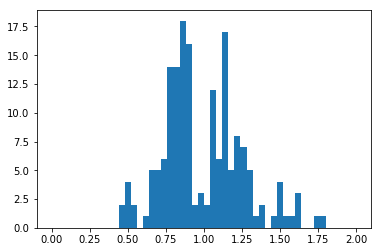

In [96]:
bins = 50
xrange = (0., 2.)
binsize = (xrange[1] - xrange[0]) / bins
fig = plt.hist(points2, bins=bins, range=xrange)
n = len(points2)
mu = np.mean(points2)
sigma = np.std(points2)
print 'The value of S is: %.3f' % sigma